In [9]:
# from rfgap import RFGAP
from rfgap import RFGAP

from sklearn.model_selection import train_test_split
from dataset import dataprep


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Read in the data and normalize

In [10]:
# TODO: Test with NumPy and Pandas, ALL METHODS and perhaps combos of each type. Problem with categorical data in Pandas?
# We should probably modify RFGAP to handle categorical data in the form of strings.

In [11]:
seed = 42
test_size = 0.2   # final test split
val_size  = 0.2   # validation fraction of the *remaining* (train+val) pool
prox_method = 'rfgap'
model_type='rf'
force_symmetric = False
non_zero_diagonal = True
max_normalize = False
oob_score = True
verbose=True
test_size=0.2
n_jobs = -1

data = pd.read_csv('/Users/aumona/Projects/RF-GAP-Python/data/iris.csv')
x, y   = dataprep(data)

n_samples = x.shape[0]
n_features = x.shape[1]



# 1) Split off TEST
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=test_size,
    random_state=seed,
    stratify=y  # good practice for classification
)

# -----------------------
# 2) Mask 20% of y_trainval as NaN (no data split)
# -----------------------
rng = np.random.RandomState(seed)
y_train_masked = np.asarray(y_train).copy()

n_mask = int(0.10 * y_train_masked.shape[0])
y_train_masked[y_train_masked.shape[0]-n_mask:] = -1

## Train the RF Model

In [12]:
rf = RFGAP(y = y_train, prox_method = prox_method, matrix_type = 'sparse', oob_score = True, non_zero_diagonal = non_zero_diagonal,
           random_state = seed, model_type=model_type, n_jobs = n_jobs, force_symmetric = force_symmetric,
           max_normalize=max_normalize, verbose=verbose)

In [13]:
rf.fit(x_train, y_train_masked)
y_train_masked

Unlabeled instances passed as input. Semi-supervised mode.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


array([ 0,  2,  1,  0,  1,  2,  1,  2,  2,  2,  2,  1,  1,  1,  1,  0,  0,
        2,  2,  0,  1,  0,  2,  0,  1,  2,  2,  0,  2,  0,  0,  1,  1,  0,
        2,  2,  1,  1,  2,  1,  0,  1,  0,  2,  0,  0,  2,  0,  0,  0,  0,
        1,  2,  1,  0,  2,  1,  2,  0,  2,  0,  1,  2,  0,  1,  1,  2,  1,
        1,  2,  0,  0,  0,  2,  1,  2,  1,  2,  2,  1,  0,  2,  1,  0,  2,
        0,  2,  1,  1,  0,  1,  2,  0,  0,  2,  2,  2,  1,  2,  0,  2,  1,
        2,  2,  0,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1], dtype=int8)

## Generate the Proximity Matrix

In [14]:
# compute/get proximity matrix and visualize with seaborn heatmap
prox = rf.get_proximities()
# prox = rf.prox_extend(x_train)

# Show diagonal values
diag = prox.diagonal()
print(diag)

[0.05225605 0.7675672  0.18352996 0.04461495 0.05281558 0.05866884
 0.04736964 0.56818247 0.04935862 0.05040949 0.05019889 0.06651045
 0.1941253  0.05672888 0.06514421 0.04820453 0.04809841 0.07689344
 0.06846502 0.05744378 0.43449917 0.05125421 0.04881768 0.04872371
 0.05660048 0.06103556 0.07035587 0.04427978 0.13677922 0.04394378
 0.04196256 0.051716   0.0504856  0.21252546 0.05167865 0.05576558
 0.05383429 0.1372567  0.05008555 0.6799744  0.04589504 0.06882264
 0.05911415 0.04066734 0.04560628 0.0507701  0.10563703 0.0454986
 0.05355906 0.04743121 0.05062016 0.05053191 0.04939731 0.0541107
 0.05284953 0.12641662 0.05454244 0.05046322 0.05084946 0.08055337
 0.17804292 0.06117623 0.12074312 0.04980479 0.7571728  0.05273485
 0.04894858 0.06897315 0.13553399 0.04955275 0.0438641  0.04806194
 0.05182607 0.74664575 0.05337925 0.44032767 0.05722715 0.04761288
 0.1872528  0.11884062 0.04996981 0.07387626 0.17576359 0.04837545
 0.05065236 0.04578523 0.04940554 0.13936327 0.12625088 0.046428

# Visualize it

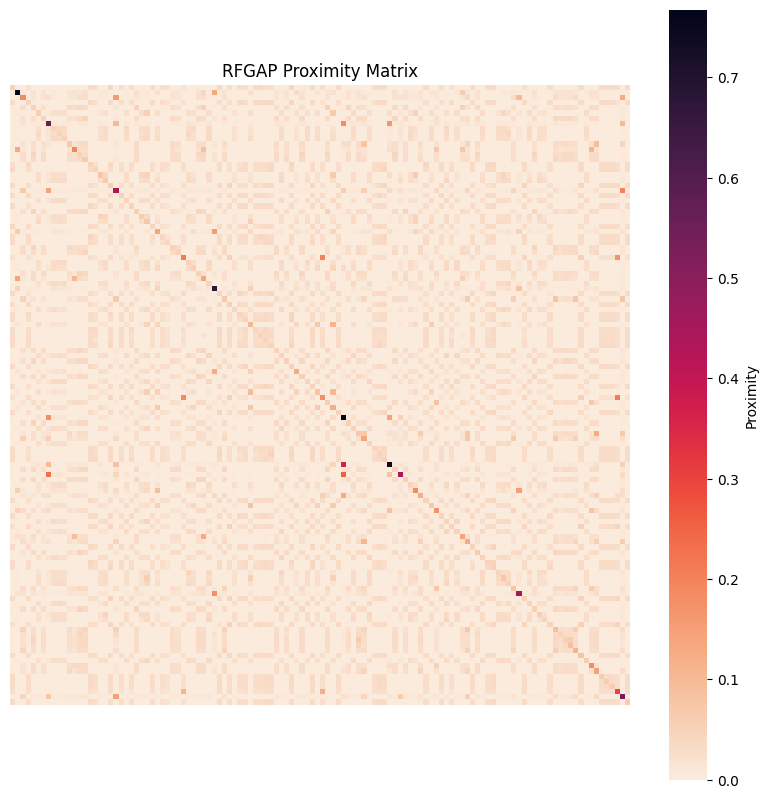

Row sums (should be close to 1):
[1.2284905 1.8465506 1.401294  1.226177  1.1670141 1.0944594 1.1824715
 1.7073336 1.0849448 1.0882931 1.0867698 1.2780726 1.3578055 1.1832058
 1.1991341 1.2343872 1.231662  1.109994  1.1097636 1.2666553 1.6979232
 1.2300661 1.084877  1.2264986 1.1837649 1.0969013 1.1014247 1.23259
 1.1989413 1.2278802 1.2321182 1.186851  1.2052343 1.5354421 1.0883989
 1.0902234 1.1835697 1.2296152 1.0845871 1.7457352 1.2305355 1.2855681
 1.2464693 1.081864  1.2365297 1.2360888 1.1339641 1.2305167 1.2213159
 1.2238122 1.2325814 1.1747155 1.08814   1.1892598 1.2318275 1.1545997
 1.1929028 1.0884721 1.2334664 1.0991317 1.5431416 1.2245171 1.1460829
 1.2400842 1.7840645 1.1818386 1.0878845 1.3447145 1.2906644 1.0853616
 1.2352529 1.2303094 1.2287469 1.8496857 1.190387  1.4909251 1.19215
 1.087391  1.2522652 1.3046091 1.2301327 1.1021715 1.3588314 1.2340498
 1.0813901 1.2637987 1.0899007 1.2473472 1.3466926 1.2314379 1.1965972
 1.0885823 1.2333091 1.2304813 1.0889404 1.10442

In [15]:
prox_mat = prox.toarray()

# mask diagonal to emphasize off-diagonal proximities
# mask = np.eye(prox_mat.shape[0], dtype=bool)
mask=None

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(prox_mat, ax=ax, cmap='rocket_r', vmin=0, vmax=prox_mat.max(),
            mask=mask,
            xticklabels=False, yticklabels=False, square=True, cbar_kws={'label': 'Proximity'})
ax.set_title(f'{prox_method.upper()} Proximity Matrix')
plt.show()

# Check row sums
row_sums = prox_mat.sum(axis=1)
print("Row sums (should be close to 1):")
print(row_sums)

## Check extended proximity computation

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


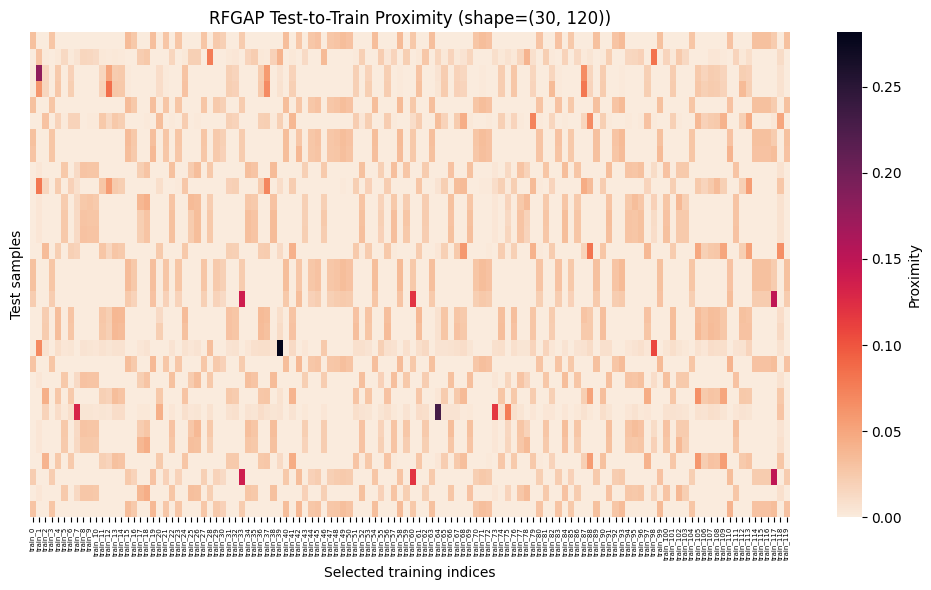

In [16]:
# selected_train_indices = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
test_prox = rf.prox_extend(x_test).toarray()
selected_train_indices = np.arange(test_prox.shape[1])
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(test_prox, ax=ax, cmap='rocket_r', vmin=0, vmax=test_prox.max(),
            xticklabels=[f'train_{i}' for i in selected_train_indices],
            yticklabels=False, cbar_kws={'label': 'Proximity'})
ax.set_xticklabels(ax.get_xticklabels(), fontsize=5) # 'ha' aligns text nicely with rotation
ax.set_xlabel('Selected training indices')
ax.set_ylabel('Test samples')
ax.set_title(f'{prox_method.upper()} Test-to-Train Proximity (shape={test_prox.shape})')
plt.tight_layout()
plt.show()